# 三角板关键点检测预测-Python API

同济子豪兄 2023-4-4

## 进入 mmpose 主目录

In [1]:
import os
os.chdir('mmpose')

## 导入工具包

In [2]:
import cv2
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import torch

import mmcv
from mmcv import imread
import mmengine
from mmengine.registry import init_default_scope

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples

from mmdet.apis import inference_detector, init_detector

In [3]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 载入待测图像

In [4]:
img_path = 'data/test_triangle/triangle_4.jpg'

In [5]:
# Image.open(img_path)

## 准备好的模型文件

In [ ]:
## 目标检测模型

# Faster R CNN
# data/faster_r_cnn_triangle.py
# checkpoint/faster_r_cnn_triangle_epoch_50_202304052050-1e56824f.pth

# data/rtmdet_tiny_triangle.py
# checkpoint/rtmdet_tiny_triangle_epoch_200_202304051235-ee3a6d30.pth

## 关键点检测模型

# data/rtmpose-s_triangle_8xb256-420e_coco-256x192.py
# checkpoint/rtmpose_s_triangle_300-a5080a04_20230406.pth

## 构建目标检测模型（任选一个运行）

In [9]:
# Faster R CNN 三角板目标检测
detector = init_detector(
    'data/faster_r_cnn_triangle.py',
    'checkpoint/faster_r_cnn_triangle_epoch_50_202304052050-1e56824f.pth',
    device=device
)

Loads checkpoint by local backend from path: checkpoint/faster_r_cnn_triangle_epoch_50_202304052050-1e56824f.pth


In [40]:
# RTMDet 三角板检测
detector = init_detector(
    'data/rtmdet_tiny_triangle.py',
    'checkpoint/rtmdet_tiny_triangle_epoch_200_202304051235-ee3a6d30.pth',
    device=device
)

Loads checkpoint by local backend from path: checkpoint/rtmdet_tiny_triangle_epoch_200_202304051235-ee3a6d30.pth


## 构建关键点检测模型

In [10]:
pose_estimator = init_pose_estimator(
    'data/rtmpose-s_triangle_8xb256-420e_coco-256x192.py',
    'checkpoint/rtmpose_s_triangle_300-a5080a04_20230406.pth',
    device=device,
    cfg_options={'model': {'test_cfg': {'output_heatmaps': True}}}
)

Loads checkpoint by local backend from path: checkpoint/rtmpose_s_triangle_300-a5080a04_20230406.pth


## 预测-目标检测

In [41]:
init_default_scope(detector.cfg.get('default_scope', 'mmdet'))

In [42]:
# 获取目标检测预测结果
detect_result = inference_detector(detector, img_path)

/environment/miniconda3/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [43]:
detect_result.keys()

['ignored_instances', 'gt_instances', 'pred_instances']

In [44]:
# 预测类别
detect_result.pred_instances.labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [45]:
# 置信度
detect_result.pred_instances.scores

tensor([0.8064, 0.7964, 0.7574, 0.1847, 0.0749, 0.0594, 0.0579, 0.0575, 0.0432,
        0.0418, 0.0412, 0.0411, 0.0392, 0.0371, 0.0352, 0.0344, 0.0339, 0.0337,
        0.0335, 0.0331, 0.0320, 0.0316, 0.0313, 0.0307, 0.0289, 0.0288, 0.0283,
        0.0282, 0.0277, 0.0276, 0.0269, 0.0259, 0.0258, 0.0257, 0.0250, 0.0244,
        0.0240, 0.0235, 0.0234, 0.0215, 0.0213, 0.0211, 0.0210, 0.0206, 0.0206,
        0.0201, 0.0197, 0.0197, 0.0195, 0.0192, 0.0192, 0.0187, 0.0184, 0.0183,
        0.0182, 0.0180, 0.0179, 0.0178, 0.0178, 0.0173, 0.0173, 0.0172, 0.0170,
        0.0170, 0.0169, 0.0165, 0.0164, 0.0161, 0.0161, 0.0161, 0.0161, 0.0160,
        0.0160, 0.0160, 0.0159, 0.0156, 0.0150, 0.0150, 0.0148, 0.0148, 0.0146,
        0.0146, 0.0145, 0.0144, 0.0144, 0.0143, 0.0143, 0.0143, 0.0141, 0.0141,
        0.0141, 0.0139, 0.0138, 0.0136, 0.0136, 0.0136, 0.0136, 0.0135, 0.0135,
        0.0134, 0.0130, 0.0129, 0.0129, 0.0129, 0.0129, 0.0128, 0.0126, 0.0126,
        0.0124, 0.0123, 0.0123, 0.0122, 

In [46]:
# 框坐标：左上角X坐标、左上角Y坐标、右下角X坐标、右下角Y坐标
# detect_result.pred_instances.bboxes

## 置信度阈值过滤，获得最终目标检测预测结果

In [47]:
# 置信度阈值
CONF_THRES = 0.5

In [48]:
pred_instance = detect_result.pred_instances.cpu().numpy()
bboxes = np.concatenate((pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
bboxes = bboxes[np.logical_and(pred_instance.labels == 0, pred_instance.scores > CONF_THRES)]
bboxes = bboxes[nms(bboxes, 0.3)][:, :4].astype('int')

In [49]:
bboxes

array([[2884,  708, 4423, 1518],
       [1709, 1805, 2576, 3641],
       [1221,  411, 2586, 1756]])

## 预测-关键点

In [50]:
# 获取每个 bbox 的关键点预测结果
pose_results = inference_topdown(pose_estimator, img_path, bboxes)

In [51]:
len(pose_results)

3

In [52]:
# 把多个bbox的pose结果打包到一起
data_samples = merge_data_samples(pose_results)

In [53]:
data_samples.keys()

['pred_fields', '_pred_heatmaps', 'gt_instances', 'pred_instances']

## 预测结果-关键点坐标

In [54]:
keypoints = data_samples.pred_instances.keypoints.astype('int')

In [55]:
keypoints

array([[[2943, 1308],
        [4431,  699],
        [4333, 1500]],

       [[2451, 1925],
        [2505, 3552],
        [1770, 3175]],

       [[1270, 1726],
        [2210,  473],
        [2526, 1190]]])

In [56]:
keypoints.shape

(3, 3, 2)

In [57]:
# 索引为 0 的框，每个关键点的坐标
keypoints[0,:,:]

array([[2943, 1308],
       [4431,  699],
       [4333, 1500]])

## 预测结果-关键点热力图

In [58]:
# 每一类关键点的预测热力图
data_samples.pred_fields.heatmaps.shape

(3, 3712, 5568)

In [59]:
kpt_idx = 1
heatmap = data_samples.pred_fields.heatmaps[kpt_idx,:,:]

In [60]:
heatmap.shape

(3712, 5568)

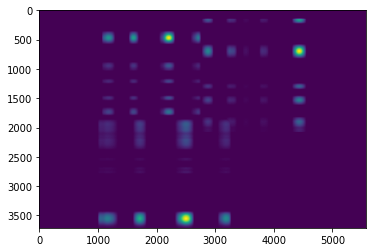

In [61]:
# 索引为 idx 的关键点，在全图上的预测热力图
plt.imshow(heatmap)
plt.show()

## OpenCV可视化

In [62]:
img_bgr = cv2.imread(img_path)

In [63]:
# 检测框的颜色
bbox_color = (150,0,0)
# 检测框的线宽
bbox_thickness = 20
# 关键点半径
kpt_radius = 70
# 连接线宽
skeleton_thickness = 30

In [64]:
# 三角板关键点检测数据集-元数据（直接从config配置文件中粘贴）
dataset_info = {
    'keypoint_info':{
        0:{'name':'angle_30','id':0,'color':[255,0,0],'type': '','swap': ''},
        1:{'name':'angle_60','id':1,'color':[0,255,0],'type': '','swap': ''},
        2:{'name':'angle_90','id':2,'color':[0,0,255],'type': '','swap': ''}
    },
    'skeleton_info': {
        0: {'link':('angle_30','angle_60'),'id': 0,'color': [100,150,200]},
        1: {'link':('angle_60','angle_90'),'id': 1,'color': [200,100,150]},
        2: {'link':('angle_90','angle_30'),'id': 2,'color': [150,120,100]}
    }
}

In [65]:
# 关键点类别和关键点ID的映射字典
label2id = {}
for each in dataset_info['keypoint_info'].items():
    label2id[each[1]['name']] = each[0]

In [66]:
for bbox_idx, bbox in enumerate(bboxes): # 遍历每个检测框

    # 画框
    img_bgr = cv2.rectangle(img_bgr, (bbox[0], bbox[1]), (bbox[2], bbox[3]), bbox_color, bbox_thickness)
    
    # 索引为 0 的框，每个关键点的坐标
    keypoints = data_samples.pred_instances.keypoints[bbox_idx,:,:].astype('int')

    # 画连线
    for skeleton_id, skeleton in dataset_info['skeleton_info'].items(): # 遍历每一种连接
        skeleton_color = skeleton['color']
        srt_kpt_id = label2id[skeleton['link'][0]] # 起始点的类别 ID
        srt_kpt_xy = keypoints[srt_kpt_id]         # 起始点的 XY 坐标
        dst_kpt_id = label2id[skeleton['link'][1]] # 终止点的类别 ID
        dst_kpt_xy = keypoints[dst_kpt_id]         # 终止点的 XY 坐标
        img_bgr = cv2.line(img_bgr, (srt_kpt_xy[0],srt_kpt_xy[1]),(dst_kpt_xy[0],dst_kpt_xy[1]),color=skeleton_color,thickness=skeleton_thickness)
    
    # 画关键点
    for kpt_idx, kpt_xy in enumerate(keypoints): # 遍历该检测框中的每一个关键点
        kpt_color = dataset_info['keypoint_info'][kpt_idx]['color']
        img_bgr = cv2.circle(img_bgr, (kpt_xy[0], kpt_xy[1]), kpt_radius, kpt_color, -1)

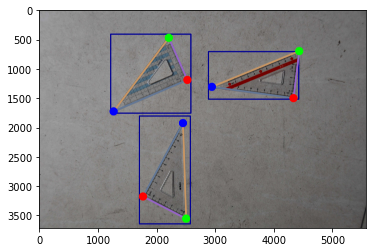

In [67]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

In [68]:
cv2.imwrite('outputs/G3_opencv.jpg', img_bgr)

True

## MMPose官方可视化工具`visualizer`

In [69]:
# 半径
pose_estimator.cfg.visualizer.radius = 50
# 线宽
pose_estimator.cfg.visualizer.line_width = 40
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
# 元数据
visualizer.set_dataset_meta(pose_estimator.dataset_meta)

04/06 09:21:42 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


In [70]:
# 元数据
# pose_estimator.dataset_meta

In [71]:
img = mmcv.imread(img_path)
img = mmcv.imconvert(img, 'bgr', 'rgb')

img_output = visualizer.add_datasample(
            'result',
            img,
            data_sample=data_samples,
            draw_gt=False,
            draw_heatmap=True,
            draw_bbox=True,
            show=False,
            show_kpt_idx=True,
            wait_time=0,
            out_file='outputs/F2_visualizer.jpg',
            kpt_thr=0.3
)

In [72]:
img_output.shape

(7424, 5568, 3)

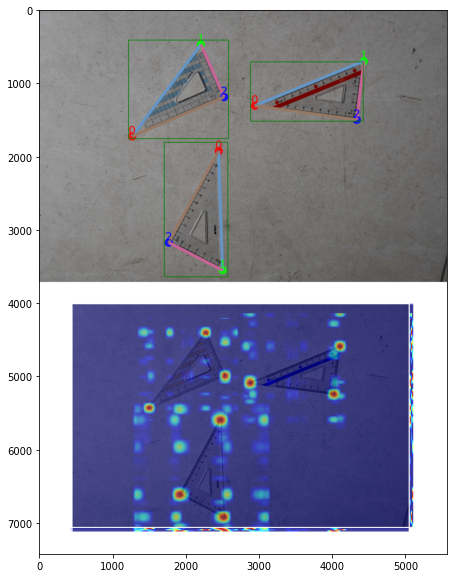

In [73]:
plt.figure(figsize=(10,10))
plt.imshow(img_output)
plt.show()